# 04 - LoFTR + MAGSAC Kaggle Pipeline

Dieses Notebook implementiert eine robuste GNSS-denied Pipeline fuer die Challenge:
- LoFTR + MAGSAC fuer Matching/Outlier-Filter
- Train/Validation Split mit festem Seed
- Anchor-basierte Sequenzlokalisierung (prev-id / next-id / bekannte GT / vorherige Predictions)
- Kombination aus Trainingsbildern **und** map.png
- Hyperparameter-Optimierung ueber die offizielle Evaluationsmetrik
- Prediction fuer Validation und Test
- Export als `submission.csv`


## Evaluation Metric

Distanz pro Bild: `d = sqrt((x_pred - x_gt)^2 + (y_pred - y_gt)^2)`

Genauigkeiten bei Schwellwerten:
- 25 px (5 m)
- 125 px (25 m)
- 500 px (100 m)

Final Score: `100 * mean(acc@25, acc@125, acc@500)`


In [1]:
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from time import perf_counter

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

try:
    from kornia.feature import LoFTR
except ImportError as e:
    raise ImportError("Dieses Notebook benoetigt kornia (LoFTR). Installiere z.B. `pip install kornia`.") from e


In [2]:
# Paths
DATA_ROOT = Path("../data/data")
TRAIN_IMG_DIR = DATA_ROOT / "train_data" / "train_images"
TEST_IMG_DIR = DATA_ROOT / "test_data" / "test_images"

TRAIN_POS_CSV = DATA_ROOT / "train_data" / "train_pos.csv"
TRAIN_CAM_CSV = DATA_ROOT / "train_data" / "train_cam.csv"
TEST_CAM_CSV = DATA_ROOT / "test_data" / "test_cam.csv"
MAP_PATH = DATA_ROOT / "map.png"

# Split / runtime config
SPLIT_SEED = 42
TRAIN_FRACTION = 0.8

# Bildgroesse fuer Runtime-Stabilitaet (None fuer full-res)
IMAGE_MAX_SIDE = 1400

# Optionales Preprocessing fuer Matching
# PREPROCESS_MODE: "none" | "gray" | "edge" | "gray_edge"
PREPROCESS_MODE = "gray_edge"
ENABLE_SHADOW_FILTER = True
CLAHE_CLIP_LIMIT = 2.5
CLAHE_GRID = (8, 8)
EDGE_CANNY_LOW = 50
EDGE_CANNY_HIGH = 150

# Baseline hyperparameters
BASE_HPARAMS = {
    "loftr_min_conf": 0.20,
    "magsac_reproj_thr": 3.0,
    "train_anchor_radius_px": 1200,
    "train_top_k": 10,
    "train_weight_power": 1.5,
    "min_train_inliers": 8,
    "map_patch_size": 1024,
    "map_search_radius": 900,
    "map_stride": 256,
    "min_map_inliers": 14,
}

SUBMISSION_OUT = Path("../build/submission.csv")

# Load tabular data
train_pos_df = pd.read_csv(TRAIN_POS_CSV)
train_cam_df = pd.read_csv(TRAIN_CAM_CSV)
test_cam_df = pd.read_csv(TEST_CAM_CSV)

train_df = train_cam_df.merge(train_pos_df, on="id", how="inner").copy()
train_df["id"] = train_df["id"].astype(int)
test_cam_df["id"] = test_cam_df["id"].astype(int)
train_df = train_df.sort_values("id").reset_index(drop=True)
test_cam_df = test_cam_df.sort_values("id").reset_index(drop=True)

# map
map_bgr = cv2.imread(str(MAP_PATH), cv2.IMREAD_COLOR)
if map_bgr is None:
    raise FileNotFoundError(f"map not found: {MAP_PATH}")
map_rgb = cv2.cvtColor(map_bgr, cv2.COLOR_BGR2RGB)
MAP_H, MAP_W = map_rgb.shape[:2]

print("train frames:", len(train_df), "test frames:", len(test_cam_df), "map:", (MAP_W, MAP_H))
print(f"preprocess mode={PREPROCESS_MODE} | shadow_filter={ENABLE_SHADOW_FILTER}")


train frames: 305 test frames: 136 map: (5000, 2500)
preprocess mode=gray_edge | shadow_filter=True


In [3]:
# Reproducible train/val split
rng = np.random.default_rng(SPLIT_SEED)
all_ids = train_df["id"].unique().copy()
rng.shuffle(all_ids)

n_fit = max(1, min(len(all_ids)-1, int(round(len(all_ids) * TRAIN_FRACTION))))
fit_ids = set(int(x) for x in all_ids[:n_fit])
val_ids = set(int(x) for x in all_ids[n_fit:])

fit_df = train_df[train_df["id"].isin(fit_ids)].copy().sort_values("id").reset_index(drop=True)
val_df = train_df[train_df["id"].isin(val_ids)].copy().sort_values("id").reset_index(drop=True)

print("fit:", len(fit_df), "val:", len(val_df))
print("val id range:", int(val_df['id'].min()), "..", int(val_df['id'].max()))


fit: 244 val: 61
val id range: 14 .. 2821


In [4]:
# Utilities: image loading/cache, ordering, metric

_IMAGE_CACHE: Dict[Tuple[str, int, Optional[int]], Tuple[np.ndarray, float]] = {}


def resolve_image_path(image_id: int, is_train: bool) -> Path:
    folder = TRAIN_IMG_DIR if is_train else TEST_IMG_DIR
    stems = [f"{int(image_id):04d}", str(int(image_id))]
    exts = [".JPG", ".jpg", ".jpeg", ".JPEG", ".png", ".PNG"]
    for st in stems:
        for ext in exts:
            p = folder / f"{st}{ext}"
            if p.exists():
                return p
    raise FileNotFoundError(f"Image not found for id={image_id} in {folder}")


def resize_keep_aspect(img_rgb: np.ndarray, max_side: Optional[int]) -> Tuple[np.ndarray, float]:
    if max_side is None:
        return img_rgb, 1.0
    h, w = img_rgb.shape[:2]
    m = max(h, w)
    if m <= int(max_side):
        return img_rgb, 1.0
    s = float(max_side) / float(m)
    nw = max(32, int(round(w * s)))
    nh = max(32, int(round(h * s)))
    out = cv2.resize(img_rgb, (nw, nh), interpolation=cv2.INTER_AREA)
    return out, s


def load_image_cached(image_id: int, split: str, max_side: Optional[int]) -> Tuple[np.ndarray, float]:
    key = (split, int(image_id), max_side)
    if key in _IMAGE_CACHE:
        return _IMAGE_CACHE[key]

    is_train = split in {"train", "fit", "val"}
    p = resolve_image_path(image_id, is_train=is_train)
    bgr = cv2.imread(str(p), cv2.IMREAD_COLOR)
    if bgr is None:
        raise RuntimeError(f"Cannot read image: {p}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb2, s = resize_keep_aspect(rgb, max_side=max_side)
    _IMAGE_CACHE[key] = (rgb2, s)
    return _IMAGE_CACHE[key]


def choose_processing_order(test_ids: List[int], min_known_train_id: int) -> List[int]:
    # Requirement: IDs below known anchor (e.g. <13) rueckwaerts
    low = sorted([i for i in test_ids if i < int(min_known_train_id)], reverse=True)
    high = sorted([i for i in test_ids if i >= int(min_known_train_id)])
    return low + high


def eval_metric_from_df(df: pd.DataFrame) -> Dict[str, float]:
    if len(df) == 0:
        return {
            "n": 0.0,
            "mean_err_px": np.nan,
            "median_err_px": np.nan,
            "acc_25": np.nan,
            "acc_125": np.nan,
            "acc_500": np.nan,
            "score": np.nan,
        }

    d = np.sqrt((df["pred_x"] - df["gt_x"]) ** 2 + (df["pred_y"] - df["gt_y"]) ** 2)
    a25 = float((d <= 25.0).mean())
    a125 = float((d <= 125.0).mean())
    a500 = float((d <= 500.0).mean())
    score = 100.0 * float(np.mean([a25, a125, a500]))

    return {
        "n": float(len(df)),
        "mean_err_px": float(d.mean()),
        "median_err_px": float(d.median()),
        "acc_25": a25,
        "acc_125": a125,
        "acc_500": a500,
        "score": score,
    }


In [5]:
# LoFTR + MAGSAC matcher
class LoFTRMagsacMatcher:
    def __init__(self, min_conf: float = 0.2, device: Optional[str] = None):
        self.min_conf = float(min_conf)
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LoFTR(pretrained="outdoor").eval().to(self.device)

    def _to_tensor(self, img_rgb: np.ndarray) -> torch.Tensor:
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        t = torch.from_numpy(gray).float()[None, None] / 255.0
        return t.to(self.device)

    @torch.inference_mode()
    def match(self, img0_rgb: np.ndarray, img1_rgb: np.ndarray):
        t0 = self._to_tensor(img0_rgb)
        t1 = self._to_tensor(img1_rgb)
        out = self.model({"image0": t0, "image1": t1})

        if "keypoints0" not in out or out["keypoints0"].numel() == 0:
            return {
                "k0": np.zeros((0, 2), dtype=np.float32),
                "k1": np.zeros((0, 2), dtype=np.float32),
                "matches": np.zeros((0, 2), dtype=np.int32),
                "conf": np.zeros((0,), dtype=np.float32),
            }

        k0 = out["keypoints0"].detach().cpu().numpy().astype(np.float32)
        k1 = out["keypoints1"].detach().cpu().numpy().astype(np.float32)
        conf_t = out.get("confidence", None)
        conf = np.ones((k0.shape[0],), dtype=np.float32) if conf_t is None else conf_t.detach().cpu().numpy().astype(np.float32)

        keep = conf >= self.min_conf
        k0 = k0[keep]
        k1 = k1[keep]
        conf = conf[keep]

        n = k0.shape[0]
        matches = np.column_stack([np.arange(n), np.arange(n)]).astype(np.int32)
        return {"k0": k0, "k1": k1, "matches": matches, "conf": conf}

    @staticmethod
    def magsac_homography(k0: np.ndarray, k1: np.ndarray, matches: np.ndarray, reproj_thr: float = 3.0):
        if matches.shape[0] < 8:
            return None, np.zeros((matches.shape[0],), dtype=bool)

        p0 = k0[matches[:, 0]].astype(np.float32)
        p1 = k1[matches[:, 1]].astype(np.float32)

        H, mask = cv2.findHomography(
            p0,
            p1,
            method=cv2.USAC_MAGSAC,
            ransacReprojThreshold=float(reproj_thr),
            maxIters=10000,
            confidence=0.999,
        )

        if H is None or mask is None:
            return None, np.zeros((matches.shape[0],), dtype=bool)

        return H, mask.ravel().astype(bool)


matcher = LoFTRMagsacMatcher(min_conf=BASE_HPARAMS["loftr_min_conf"])
print("matcher device:", matcher.device)


matcher device: cuda


In [6]:
# Anchor-based localization building blocks
fit_pos = fit_df[["id", "x_pixel", "y_pixel"]].copy().sort_values("id")
fit_ids_arr = fit_pos["id"].to_numpy(dtype=np.int32)
fit_xy_arr = fit_pos[["x_pixel", "y_pixel"]].to_numpy(dtype=np.float32)

# known GT anchors for train
all_train_gt = {int(r.id): (float(r.x_pixel), float(r.y_pixel)) for r in train_df.itertuples(index=False)}
fit_train_gt = {int(r.id): (float(r.x_pixel), float(r.y_pixel)) for r in fit_df.itertuples(index=False)}


def apply_shadow_filter_rgb(img_rgb: np.ndarray, clip_limit: float = 2.5, grid: Tuple[int, int] = (8, 8)) -> np.ndarray:
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=float(clip_limit), tileGridSize=tuple(grid))
    l2 = clahe.apply(l)
    lab2 = cv2.merge([l2, a, b])
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)


def preprocess_for_matching(
    img_rgb: np.ndarray,
    mode: str = "none",
    shadow_filter: bool = False,
    canny_low: int = 50,
    canny_high: int = 150,
) -> np.ndarray:
    mode = str(mode).lower()
    proc = img_rgb

    if bool(shadow_filter):
        proc = apply_shadow_filter_rgb(proc, clip_limit=CLAHE_CLIP_LIMIT, grid=CLAHE_GRID)

    if mode == "none":
        return proc

    gray = cv2.cvtColor(proc, cv2.COLOR_RGB2GRAY)

    if mode == "gray":
        return cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    if mode == "edge":
        edges = cv2.Canny(gray, int(canny_low), int(canny_high))
        return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    if mode == "gray_edge":
        edges = cv2.Canny(gray, int(canny_low), int(canny_high))
        mix = cv2.addWeighted(gray, 0.75, edges, 0.25, 0.0)
        return cv2.cvtColor(mix, cv2.COLOR_GRAY2RGB)

    raise ValueError(f"Unknown PREPROCESS_MODE: {mode}")


def get_query_match_image(query_img: np.ndarray) -> np.ndarray:
    return preprocess_for_matching(
        query_img,
        mode=PREPROCESS_MODE,
        shadow_filter=ENABLE_SHADOW_FILTER,
        canny_low=EDGE_CANNY_LOW,
        canny_high=EDGE_CANNY_HIGH,
    )


_TRAIN_MATCH_CACHE: Dict[Tuple[int, str, bool, int, int], np.ndarray] = {}


def get_train_match_image(train_id: int) -> np.ndarray:
    key = (
        int(train_id),
        str(PREPROCESS_MODE).lower(),
        bool(ENABLE_SHADOW_FILTER),
        int(EDGE_CANNY_LOW),
        int(EDGE_CANNY_HIGH),
    )
    if key in _TRAIN_MATCH_CACHE:
        return _TRAIN_MATCH_CACHE[key]

    tr_img, _ = load_image_cached(int(train_id), split="fit", max_side=IMAGE_MAX_SIDE)
    tr_match = preprocess_for_matching(
        tr_img,
        mode=PREPROCESS_MODE,
        shadow_filter=ENABLE_SHADOW_FILTER,
        canny_low=EDGE_CANNY_LOW,
        canny_high=EDGE_CANNY_HIGH,
    )
    _TRAIN_MATCH_CACHE[key] = tr_match
    return tr_match


def project_query_center_with_H(H: np.ndarray, query_shape: Tuple[int, int, int], offset_xy=(0.0, 0.0)) -> Tuple[float, float]:
    hq, wq = query_shape[:2]
    cq = np.array([wq / 2.0, hq / 2.0, 1.0], dtype=np.float64)
    p = H @ cq
    if abs(float(p[2])) < 1e-12:
        return np.nan, np.nan
    uv = p[:2] / p[2]
    return float(uv[0] + offset_xy[0]), float(uv[1] + offset_xy[1])


def get_anchor_xy(image_id: int, known_xy: Dict[int, Tuple[float, float]]) -> Tuple[Tuple[float, float], str]:
    i = int(image_id)
    if (i - 1) in known_xy:
        return known_xy[i - 1], "prev_id"
    if (i + 1) in known_xy:
        return known_xy[i + 1], "next_id"
    if len(known_xy) > 0:
        nearest = min(known_xy.keys(), key=lambda k: abs(int(k) - i))
        return known_xy[nearest], f"nearest_id_{nearest}"
    return (MAP_W * 0.5, MAP_H * 0.5), "map_center"


def select_train_candidates(anchor_xy: Tuple[float, float], radius_px: float, top_k: int) -> np.ndarray:
    a = np.asarray(anchor_xy, dtype=np.float32)[None, :]
    d = np.linalg.norm(fit_xy_arr - a, axis=1)

    idx = np.where(d <= float(radius_px))[0]
    if idx.size == 0:
        idx = np.argsort(d)[: int(max(1, top_k))]
    else:
        idx = idx[np.argsort(d[idx])[: int(max(1, top_k))]]

    return fit_ids_arr[idx]


def coarse_localize_with_train(
    query_id: int,
    query_img_match: np.ndarray,
    anchor_xy: Tuple[float, float],
    hparams: Dict[str, float],
):
    cand_ids = select_train_candidates(
        anchor_xy=anchor_xy,
        radius_px=hparams["train_anchor_radius_px"],
        top_k=int(hparams["train_top_k"]),
    )

    scored = []
    for cid in cand_ids:
        tr_img_match = get_train_match_image(int(cid))
        m = matcher.match(query_img_match, tr_img_match)
        H, inl = matcher.magsac_homography(m["k0"], m["k1"], m["matches"], reproj_thr=hparams["magsac_reproj_thr"])
        s = int(inl.sum())
        if s < int(hparams["min_train_inliers"]):
            continue
        scored.append((s, int(cid), H))

    if len(scored) == 0:
        return {
            "coarse_xy": (float(anchor_xy[0]), float(anchor_xy[1])),
            "best_train_id": -1,
            "best_score": 0,
            "num_candidates": int(len(cand_ids)),
            "num_valid": 0,
        }

    scored.sort(key=lambda x: x[0], reverse=True)
    top = scored[: int(max(1, hparams["train_top_k"]))]

    w = np.asarray([float(s) for s, _, _ in top], dtype=np.float64)
    w = np.power(w, float(hparams["train_weight_power"]))
    pos = np.asarray([all_train_gt[cid] for _, cid, _ in top], dtype=np.float64)

    coarse_xy = tuple((w[:, None] * pos).sum(axis=0) / max(1e-9, w.sum()))

    return {
        "coarse_xy": (float(coarse_xy[0]), float(coarse_xy[1])),
        "best_train_id": int(top[0][1]),
        "best_score": int(top[0][0]),
        "num_candidates": int(len(cand_ids)),
        "num_valid": int(len(scored)),
    }


def iter_map_patches(anchor_xy: Tuple[float, float], patch_size: int, search_radius: int, stride: int):
    ps = int(patch_size)
    if ps <= 32:
        return

    half = ps // 2
    x_c = int(round(anchor_xy[0]))
    y_c = int(round(anchor_xy[1]))

    xs = range(x_c - int(search_radius), x_c + int(search_radius) + 1, int(stride))
    ys = range(y_c - int(search_radius), y_c + int(search_radius) + 1, int(stride))

    seen = set()
    for yc in ys:
        for xc in xs:
            x0 = int(np.clip(xc - half, 0, max(0, MAP_W - ps)))
            y0 = int(np.clip(yc - half, 0, max(0, MAP_H - ps)))
            key = (x0, y0)
            if key in seen:
                continue
            seen.add(key)
            patch = map_rgb[y0:y0 + ps, x0:x0 + ps]
            if patch.size == 0:
                continue
            yield x0, y0, patch


def refine_with_map(query_img: np.ndarray, query_img_match: np.ndarray, coarse_xy: Tuple[float, float], hparams: Dict[str, float]):
    best = None
    for x0, y0, patch in iter_map_patches(
        anchor_xy=coarse_xy,
        patch_size=int(hparams["map_patch_size"]),
        search_radius=int(hparams["map_search_radius"]),
        stride=int(hparams["map_stride"]),
    ):
        patch_match = preprocess_for_matching(
            patch,
            mode=PREPROCESS_MODE,
            shadow_filter=ENABLE_SHADOW_FILTER,
            canny_low=EDGE_CANNY_LOW,
            canny_high=EDGE_CANNY_HIGH,
        )
        m = matcher.match(query_img_match, patch_match)
        H, inl = matcher.magsac_homography(m["k0"], m["k1"], m["matches"], reproj_thr=hparams["magsac_reproj_thr"])
        s = int(inl.sum())

        if best is None or s > best["score"]:
            best = {"score": s, "H": H, "x0": x0, "y0": y0}

    if best is None or best["H"] is None or int(best["score"]) < int(hparams["min_map_inliers"]):
        return {
            "pred_xy": (float(coarse_xy[0]), float(coarse_xy[1])),
            "map_score": 0 if best is None else int(best["score"]),
            "used_map": False,
        }

    pred_x, pred_y = project_query_center_with_H(best["H"], query_img.shape, offset_xy=(best["x0"], best["y0"]))
    if not (np.isfinite(pred_x) and np.isfinite(pred_y)):
        return {
            "pred_xy": (float(coarse_xy[0]), float(coarse_xy[1])),
            "map_score": int(best["score"]),
            "used_map": False,
        }

    pred_x = float(np.clip(pred_x, 0, MAP_W - 1))
    pred_y = float(np.clip(pred_y, 0, MAP_H - 1))

    return {
        "pred_xy": (pred_x, pred_y),
        "map_score": int(best["score"]),
        "used_map": True,
    }


In [7]:
def localize_split(
    query_df: pd.DataFrame,
    split_name: str,
    known_xy_init: Dict[int, Tuple[float, float]],
    hparams: Dict[str, float],
    reverse_prefix_from_train13: bool = False,
):
    known_xy = dict(known_xy_init)

    ids = query_df["id"].astype(int).tolist()
    if split_name == "test" and reverse_prefix_from_train13:
        min_train_id = int(train_df["id"].min())
        order = choose_processing_order(ids, min_known_train_id=min_train_id)
    else:
        order = sorted(ids)

    gt_by_id = {}
    if "x_pixel" in query_df.columns and "y_pixel" in query_df.columns:
        for r in query_df.itertuples(index=False):
            gt_by_id[int(r.id)] = (float(r.x_pixel), float(r.y_pixel))

    rows = []
    t0 = perf_counter()
    for j, qid in enumerate(order, 1):
        q_img, _ = load_image_cached(int(qid), split=("val" if split_name == "val" else "test"), max_side=IMAGE_MAX_SIDE)
        q_img_match = get_query_match_image(q_img)

        anchor_xy, anchor_src = get_anchor_xy(int(qid), known_xy)
        coarse = coarse_localize_with_train(int(qid), q_img_match, anchor_xy, hparams=hparams)
        refined = refine_with_map(q_img, q_img_match, coarse_xy=coarse["coarse_xy"], hparams=hparams)

        pred_xy = refined["pred_xy"]
        known_xy[int(qid)] = pred_xy  # make prediction available as next anchor

        gt = gt_by_id.get(int(qid), (np.nan, np.nan))
        err = np.nan if np.isnan(gt[0]) else float(np.hypot(pred_xy[0] - gt[0], pred_xy[1] - gt[1]))

        rows.append(
            {
                "id": int(qid),
                "pred_x": float(pred_xy[0]),
                "pred_y": float(pred_xy[1]),
                "gt_x": float(gt[0]),
                "gt_y": float(gt[1]),
                "err_px": err,
                "anchor_source": anchor_src,
                "coarse_best_train_id": int(coarse["best_train_id"]),
                "coarse_best_score": int(coarse["best_score"]),
                "coarse_num_valid": int(coarse["num_valid"]),
                "map_score": int(refined["map_score"]),
                "used_map": bool(refined["used_map"]),
            }
        )

        if j % 10 == 0:
            dt = perf_counter() - t0
            print(f"[{split_name}] done {j}/{len(order)} | avg {dt/max(1,j):.2f}s per frame")

    pred_df = pd.DataFrame(rows).sort_values("id").reset_index(drop=True)
    return pred_df


In [8]:
# Baseline validation run
matcher.min_conf = float(BASE_HPARAMS["loftr_min_conf"])

val_pred_df = localize_split(
    query_df=val_df,
    split_name="val",
    known_xy_init=fit_train_gt,   # bekannte GT als globale Anker
    hparams=BASE_HPARAMS,
    reverse_prefix_from_train13=False,
)

val_metrics = eval_metric_from_df(val_pred_df.dropna(subset=["gt_x", "gt_y"]))
print("Baseline val metrics:")
print(pd.Series(val_metrics))


[val] done 10/61 | avg 20.68s per frame
[val] done 20/61 | avg 20.70s per frame
[val] done 30/61 | avg 20.01s per frame
[val] done 40/61 | avg 20.02s per frame
[val] done 50/61 | avg 19.64s per frame
[val] done 60/61 | avg 19.09s per frame
Baseline val metrics:
n                 61.000000
mean_err_px      241.700334
median_err_px     93.014410
acc_25             0.180328
acc_125            0.573770
acc_500            0.819672
score             52.459016
dtype: float64


In [9]:
# Hyperparameter optimization (random search)
SEARCH_SPACE = {
    "loftr_min_conf": [0.15, 0.20, 0.25, 0.30],
    "magsac_reproj_thr": [2.0, 3.0, 4.0],
    "train_anchor_radius_px": [800, 1000, 1200, 1500],
    "train_top_k": [6, 8, 10, 14],
    "train_weight_power": [1.0, 1.5, 2.0],
    "min_train_inliers": [6, 8, 12],
    "map_patch_size": [768, 896, 1024, 1280],
    "map_search_radius": [500, 700, 900, 1200],
    "map_stride": [192, 256, 320],
    "min_map_inliers": [8, 12, 16, 24],
}


def sample_hparams(rng: np.random.Generator) -> Dict[str, float]:
    hp = {}
    for k, vals in SEARCH_SPACE.items():
        hp[k] = vals[int(rng.integers(0, len(vals)))]
    return hp


def optimize_hparams(
    n_trials: int = 10,
    val_limit: int = 40,
    seed: int = 123,
) -> Tuple[pd.DataFrame, Dict[str, float], pd.DataFrame, Dict[str, float]]:
    rng = np.random.default_rng(seed)
    trials = []

    # contiguous subset for sequential-anchor realism
    val_sub = val_df.sort_values("id").head(int(min(val_limit, len(val_df))))

    best_score = -1.0
    best_hp = None
    best_pred = None
    best_metrics = None

    for t in range(1, n_trials + 1):
        hp = sample_hparams(rng)
        matcher.min_conf = float(hp["loftr_min_conf"])

        t0 = perf_counter()
        pred = localize_split(
            query_df=val_sub,
            split_name="val",
            known_xy_init=fit_train_gt,
            hparams=hp,
            reverse_prefix_from_train13=False,
        )
        met = eval_metric_from_df(pred.dropna(subset=["gt_x", "gt_y"]))
        dt = perf_counter() - t0

        row = {"trial": t, **hp, **met, "runtime_s": float(dt)}
        trials.append(row)
        print(f"trial={t:02d} score={met['score']:.3f} mean_err={met['mean_err_px']:.2f} runtime={dt:.1f}s")

        if met["score"] > best_score:
            best_score = float(met["score"])
            best_hp = dict(hp)
            best_pred = pred.copy()
            best_metrics = dict(met)

    trials_df = pd.DataFrame(trials).sort_values("score", ascending=False).reset_index(drop=True)
    return trials_df, best_hp, best_pred, best_metrics


In [10]:
# Run hyperparameter optimization (adjust n_trials/val_limit based on compute budget)
RUN_OPTIMIZATION = True

if RUN_OPTIMIZATION:
    trials_df, best_hp, best_val_pred_df, best_val_metrics = optimize_hparams(
        n_trials=8,
        val_limit=min(50, len(val_df)),
        seed=321,
    )
    display(trials_df.head(10))
    print("best hp:", best_hp)
    print("best val metrics:", best_val_metrics)
else:
    trials_df = pd.DataFrame()
    best_hp = dict(BASE_HPARAMS)
    best_val_pred_df = val_pred_df.copy()
    best_val_metrics = val_metrics


[val] done 10/50 | avg 15.76s per frame
[val] done 20/50 | avg 16.56s per frame
[val] done 30/50 | avg 16.09s per frame
[val] done 40/50 | avg 16.47s per frame
[val] done 50/50 | avg 16.57s per frame
trial=01 score=58.667 mean_err=149.73 runtime=828.5s
[val] done 10/50 | avg 14.93s per frame
[val] done 20/50 | avg 16.49s per frame
[val] done 30/50 | avg 15.83s per frame
[val] done 40/50 | avg 16.53s per frame
[val] done 50/50 | avg 16.77s per frame
trial=02 score=57.333 mean_err=178.01 runtime=838.3s
[val] done 10/50 | avg 13.13s per frame
[val] done 20/50 | avg 14.22s per frame
[val] done 30/50 | avg 13.57s per frame
[val] done 40/50 | avg 14.05s per frame
[val] done 50/50 | avg 14.27s per frame
trial=03 score=51.333 mean_err=194.86 runtime=713.3s
[val] done 10/50 | avg 36.83s per frame
[val] done 20/50 | avg 37.40s per frame
[val] done 30/50 | avg 35.96s per frame
[val] done 40/50 | avg 36.34s per frame
[val] done 50/50 | avg 36.48s per frame
trial=04 score=26.667 mean_err=594.84 run

,trial,loftr_min_conf,magsac_reproj_thr,train_anchor_radius_px,train_top_k,train_weight_power,min_train_inliers,map_patch_size,map_search_radius,map_stride,min_map_inliers,n,mean_err_px,median_err_px,acc_25,acc_125,acc_500,score,runtime_s
0,1,0.20,3.0,800,14,1.5,8,896,900,256,16,50.0,149.728930,55.839696,0.24,0.60,0.92,58.666667,828.536317
1,2,0.25,4.0,800,10,2.0,6,1024,700,192,24,50.0,178.014027,98.707527,0.20,0.64,0.88,57.333333,838.265492
2,8,0.15,4.0,1500,14,2.0,6,768,700,192,12,50.0,238.085266,120.103869,0.22,0.56,0.82,53.333333,838.614335
3,6,0.15,2.0,1200,8,1.5,8,1024,500,320,24,50.0,196.955311,116.472054,0.14,0.58,0.88,53.333333,331.896184
4,5,0.15,3.0,1500,6,2.0,12,768,1200,192,24,50.0,206.728417,110.016725,0.06,0.62,0.90,52.666667,1437.188270
5,3,0.25,4.0,800,8,1.5,12,768,700,192,24,50.0,194.855622,115.896216,0.12,0.54,0.88,51.333333,713.301383
6,7,0.15,3.0,800,8,2.0,6,896,500,320,8,50.0,366.782341,344.476164,0.04,0.24,0.72,33.333333,315.049107
7,4,0.25,4.0,1200,6,1.5,12,1280,1200,192,12,50.0,594.844992,480.320987,0.04,0.24,0.52,26.666667,1824.181603


best hp: {'loftr_min_conf': 0.2, 'magsac_reproj_thr': 3.0, 'train_anchor_radius_px': 800, 'train_top_k': 14, 'train_weight_power': 1.5, 'min_train_inliers': 8, 'map_patch_size': 896, 'map_search_radius': 900, 'map_stride': 256, 'min_map_inliers': 16}
best val metrics: {'n': 50.0, 'mean_err_px': 149.72893008421693, 'median_err_px': 55.83969566857422, 'acc_25': 0.24, 'acc_125': 0.6, 'acc_500': 0.92, 'score': 58.666666666666664}


In [11]:
# Final run on full validation and test
final_hp = dict(best_hp) if best_hp is not None else dict(BASE_HPARAMS)
matcher.min_conf = float(final_hp["loftr_min_conf"])

# full val evaluation
val_final_df = localize_split(
    query_df=val_df,
    split_name="val",
    known_xy_init=fit_train_gt,
    hparams=final_hp,
    reverse_prefix_from_train13=False,
)
val_final_metrics = eval_metric_from_df(val_final_df.dropna(subset=["gt_x", "gt_y"]))
print("Final val metrics:")
print(pd.Series(val_final_metrics))

# test prediction
# requirement: IDs starting at 1 are processed backwards from known train anchor (id 13)
test_final_df = localize_split(
    query_df=test_cam_df,
    split_name="test",
    known_xy_init=all_train_gt,
    hparams=final_hp,
    reverse_prefix_from_train13=True,
)
print("test predicted:", len(test_final_df))

display(test_final_df.head())


[val] done 10/61 | avg 15.97s per frame
[val] done 20/61 | avg 16.86s per frame
[val] done 30/61 | avg 16.36s per frame
[val] done 40/61 | avg 16.82s per frame
[val] done 50/61 | avg 16.94s per frame
[val] done 60/61 | avg 16.77s per frame
Final val metrics:
n                 61.000000
mean_err_px      133.025437
median_err_px     49.303951
acc_25             0.229508
acc_125            0.655738
acc_500            0.934426
score             60.655738
dtype: float64
[test] done 10/136 | avg 16.73s per frame
[test] done 20/136 | avg 16.63s per frame
[test] done 30/136 | avg 17.02s per frame
[test] done 40/136 | avg 17.30s per frame
[test] done 50/136 | avg 17.36s per frame
[test] done 60/136 | avg 17.24s per frame
[test] done 70/136 | avg 16.51s per frame
[test] done 80/136 | avg 16.09s per frame
[test] done 90/136 | avg 15.97s per frame
[test] done 100/136 | avg 16.16s per frame
[test] done 110/136 | avg 16.25s per frame
[test] done 120/136 | avg 16.21s per frame
[test] done 130/136 | a

,id,pred_x,pred_y,gt_x,gt_y,err_px,anchor_source,coarse_best_train_id,coarse_best_score,coarse_num_valid,map_score,used_map
0,1,2021.196023,1800.623016,NaN,NaN,NaN,next_id,2684,9,9,13,False
1,2,1997.921585,1731.455680,NaN,NaN,NaN,next_id,2529,9,7,17,True
2,3,2513.960654,1673.153256,NaN,NaN,NaN,next_id,2529,10,4,11,False
3,4,2517.091528,1649.719221,NaN,NaN,NaN,next_id,64,9,4,10,False
4,5,2560.509241,1687.804021,NaN,NaN,NaN,next_id,18,12,10,10,False


In [12]:
# Write submission.csv
submission_df = test_final_df[["id", "pred_x", "pred_y"]].copy()
submission_df = submission_df.rename(columns={"pred_x": "x_pixel", "pred_y": "y_pixel"})
submission_df = submission_df.sort_values("id").reset_index(drop=True)

SUBMISSION_OUT.parent.mkdir(parents=True, exist_ok=True)
submission_df.to_csv(SUBMISSION_OUT, index=False)
print("written:", SUBMISSION_OUT)
print(submission_df.head())


written: ../build/submission.csv
   id      x_pixel      y_pixel
0   1  2021.196023  1800.623016
1   2  1997.921585  1731.455680
2   3  2513.960654  1673.153256
3   4  2517.091528  1649.719221
4   5  2560.509241  1687.804021


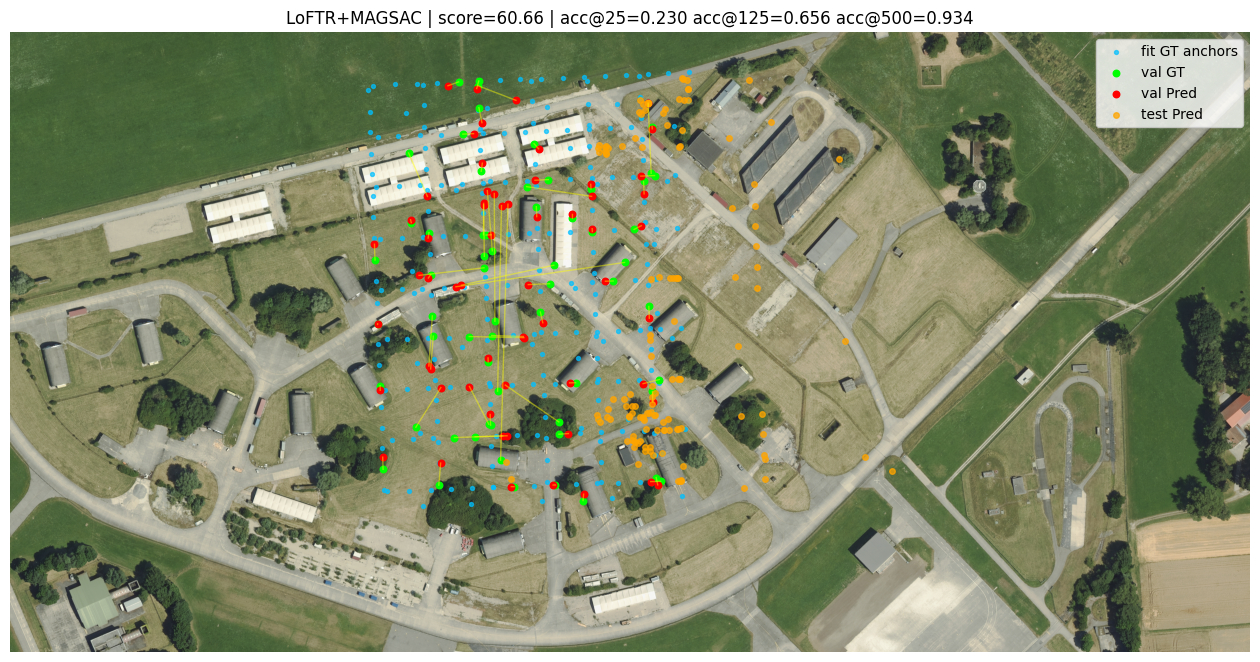

In [13]:
# Visualization: camera positions and val/test predictions on map.png
fit_xy = fit_df[["x_pixel", "y_pixel"]].to_numpy(dtype=np.float32)

plt.figure(figsize=(16, 10))
plt.imshow(map_rgb)

# known GT anchors (fit split)
plt.scatter(fit_xy[:, 0], fit_xy[:, 1], s=8, c="deepskyblue", label="fit GT anchors", alpha=0.7)

# val gt + val pred + connecting lines
if len(val_final_df) > 0:
    v = val_final_df.dropna(subset=["gt_x", "gt_y"]).copy()
    for r in v.itertuples(index=False):
        plt.plot([r.pred_x, r.gt_x], [r.pred_y, r.gt_y], color="yellow", alpha=0.45, linewidth=1.0)
    plt.scatter(v["gt_x"], v["gt_y"], s=22, c="lime", label="val GT")
    plt.scatter(v["pred_x"], v["pred_y"], s=22, c="red", label="val Pred")

# test preds
if len(test_final_df) > 0:
    plt.scatter(test_final_df["pred_x"], test_final_df["pred_y"], s=16, c="orange", label="test Pred", alpha=0.75)

plt.title(
    f"LoFTR+MAGSAC | score={val_final_metrics['score']:.2f} | "
    f"acc@25={val_final_metrics['acc_25']:.3f} acc@125={val_final_metrics['acc_125']:.3f} acc@500={val_final_metrics['acc_500']:.3f}"
)
plt.legend(loc="upper right")
plt.axis("off")
plt.show()


In [14]:
# Optional diagnostics
display(val_final_df[[
    "id", "pred_x", "pred_y", "gt_x", "gt_y", "err_px",
    "anchor_source", "coarse_best_train_id", "coarse_best_score", "map_score", "used_map"
]].head(30))

print("Anchor source distribution (val):")
print(val_final_df["anchor_source"].value_counts(dropna=False))


,id,pred_x,pred_y,gt_x,gt_y,err_px,anchor_source,coarse_best_train_id,coarse_best_score,map_score,used_map
0,14,2572.633106,286.928662,2584.838216,569.575778,282.910510,prev_id,13,2472,11,False
1,19,2312.474261,1863.190763,2310.170891,1888.884916,25.797190,prev_id,2529,464,78,True
2,23,2267.372975,735.289000,2267.377316,751.323745,16.034746,prev_id,22,3064,36,True
3,27,1924.246398,638.974416,1944.109308,881.632099,243.469272,prev_id,26,3290,12,False
4,28,1952.234518,650.733833,1954.878894,1165.583698,514.856656,prev_id,2593,13,11,False
5,29,1981.370882,699.544899,1965.704955,1447.604773,748.223894,prev_id,2778,9,9,False
6,30,2007.439929,693.866986,1977.600712,1726.207573,1032.771739,prev_id,2580,12,9,False
7,35,1614.798196,756.601131,1617.589353,768.682623,12.399718,prev_id,34,2662,17,True
8,36,1682.681053,662.682127,1606.662369,487.115857,191.317421,prev_id,2622,2030,12,False
9,47,2344.656356,662.352089,2082.553379,623.067009,265.030731,prev_id,46,3504,14,False


Anchor source distribution (val):
anchor_source
prev_id    60
next_id     1
Name: count, dtype: int64
